In [2]:
# import libraries

# Data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report


# TensorFlow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD

# Global setting
%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
# Read the training and test sets
training_df = pd.read_csv("../data/preprocessed/training_set.csv")
testing_df = pd.read_csv("../data/preprocessed/testing_set.csv")

In [4]:
# Splitt the data into training and testing sets
X_train, X_test, y_train, y_test = training_df.drop('Target', axis=1),testing_df.drop('Target', axis=1), training_df['Target'],  testing_df['Target']

## Functions to help the models


In [6]:
# a list to hold all model scores to be used later
model_score_list = []

# A function to plot training and validation accuracy and loss
def plot_scores(history):
    hist = pd.DataFrame(history.history)
    plt.figure(figsize=(16, 5))
    plt.subplot(1,2,1)
    plt.title("Model_1 Training and test loss")
    plt.plot(hist['loss'], label='training_loss')
    plt.plot(hist['val_loss'], label='Test_loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title("Model_1 Training and test accuracy")
    plt.plot(hist['accuracy'], label='training_accuracy')
    plt.plot(hist['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.show()


# Create a function to get scores
def get_scores(y_test, pred, model:'str'):
    """
    This functions takes the Test set, predicted values and the model name
    It them get the socres and create a dictionary for the model scores to be appended to the
    score list
    """
    # round the output from the model to get the required classes since it's binary
    pred = tf.round(pred)
    # get the scores
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred,average='weighted')

    # append the scores to the list
    model_score_list.append({'Model':model, 'Accuracy':acc, 'Precision':prec, 'Recall':recall, 'F1':f1})

## Building Model 1
1. One hidden Layer with 50 Units(Neurons)
2. One output layer('Softmax activation')

In [8]:
# set random seed
tf.random.set_seed(42)

# Create a Sequential Model
model_1 = Sequential([
    InputLayer(shape=X_train.iloc[0].shape),
    Dense(50, activation='relu', name='hidden_layer'),
    Dense(1, activation='sigmoid', name='output_layer')
], name='Model_1')


# compile the model
model_1.compile(
    loss=BinaryCrossentropy,
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)


# fit the model
history = model_1.fit(X_train, y_train, batch_size=100, epochs=100, validation_split=0.2, verbose=0)
# Get the model's summary
model_1.summary()

Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 50)             │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,455 (25.22 KB)

 Trainable params: 2,151 (8.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,304 (16.82 KB)

In [9]:
# Get predictions
pred_1 = model_1.predict(X_test)

1886/1886 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


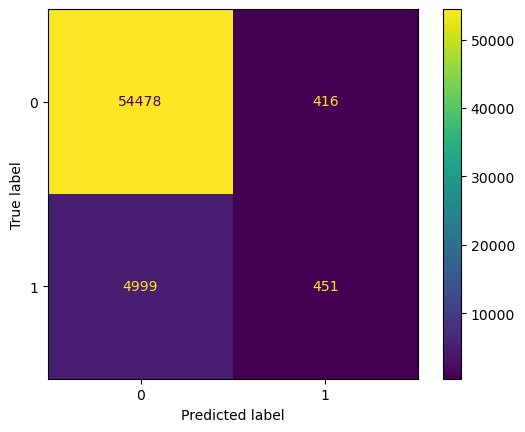

In [10]:
# Display confusion matrix
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test, tf.round(pred_1))
plt.show()

In [11]:
# print the classification report
print(classification_report(y_test, tf.round(pred_1)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     54894
           1       0.52      0.08      0.14      5450

    accuracy                           0.91     60344
   macro avg       0.72      0.54      0.55     60344
weighted avg       0.88      0.91      0.88     60344



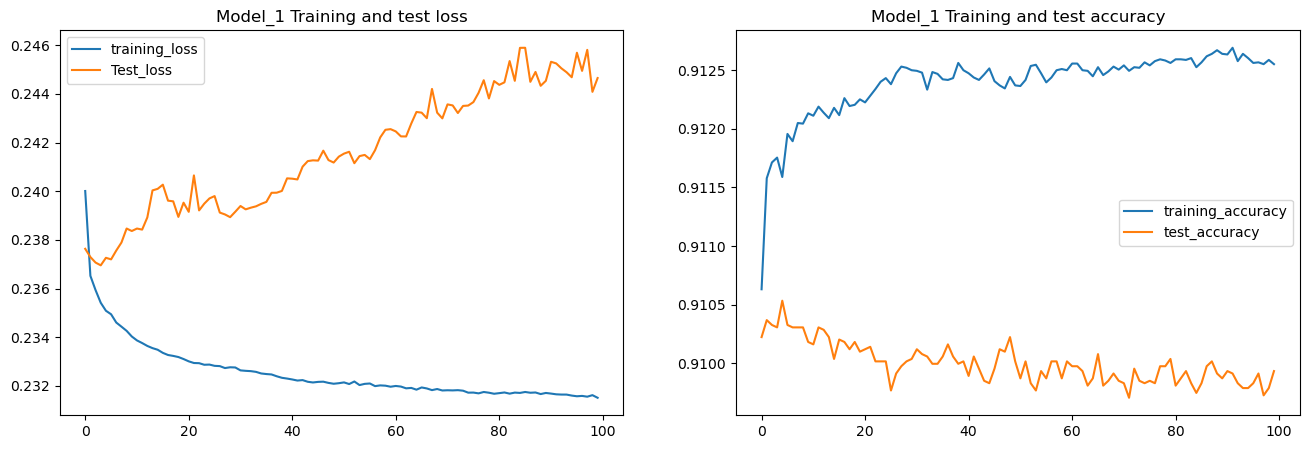

In [12]:
# let plot the model's Accuracy and loss
plot_scores(history)

In [13]:
# Get the model's scores and save them
get_scores(y_test, pred_1, 'model_1')

<b>Model_1 Evaluation</b> <br>
From the metrics, the model is performing well with an accuracy of 91%. However, when looking at the confusion matrix, it appears that due to the high class imbalance, the model has learned more from the class without heart disease, as it has more instances in the dataset. To address this issue, we will attempt to use more hidden layers and neurons to see if the model can better learn the patterns in the data.

## Building Model 2
3 hidden units
1 output layer

1. Layer one 100 units(neurons)
2. Layer two 50 units(neurons)
3. Layer three 30 units(neurons)
4. Layer 4(output) 1 unit, activation=sigmoid
5. Train the model twice the time model one took

In [16]:
# Create a random seed
tf.random.set_seed(42)

# build the model
model_2 = Sequential([
    InputLayer(shape=X_train.iloc[0].shape),
    Dense(100, activation='relu', name='hidden_layer_1'),
    Dense(50, activation='relu', name='hidden_layer_2'),
    Dense(30, activation='relu', name='hidden_layer_3'),
    Dense(1, activation='sigmoid', name='output_layer')
])

# compile the model
model_2.compile(
    loss=BinaryCrossentropy,
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

# fit the model on the training set
history = model_2.fit(X_train, y_train, epochs=200, verbose=0, batch_size=32, validation_split=0.2)

# get model summary
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 100)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,435 (126.70 KB)

 Trainable params: 10,811 (42.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,624 (84.47 KB)

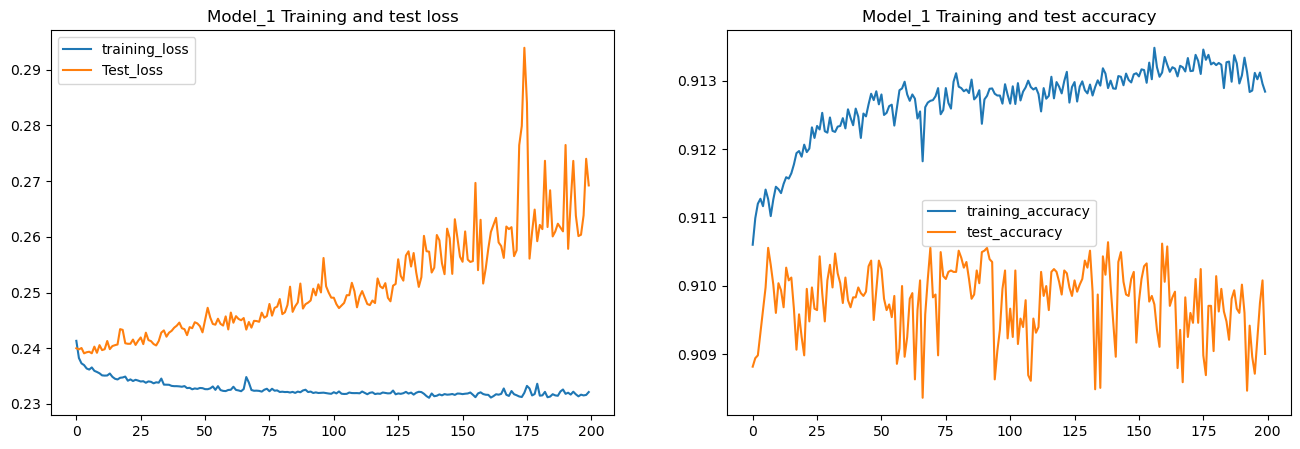

In [36]:
# let plot the model's Accuracy and loss
plot_scores(history)

In [17]:
# Make prediction with the model and draw the confusion matrix
pred_2 = model_2.predict(X_test)

1886/1886 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


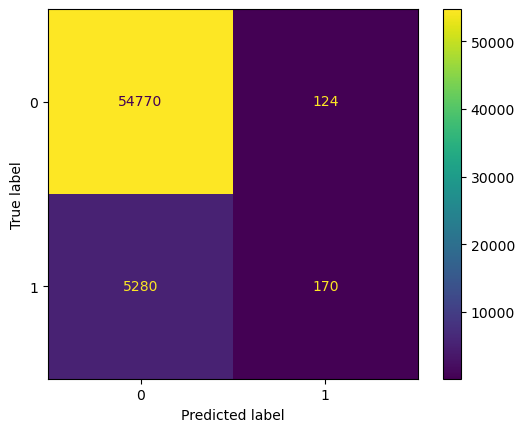

In [18]:
# get confusion matrix
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test, tf.round(pred_2))
plt.show()

In [19]:
# print the classification report
print(classification_report(y_test, tf.round(pred_2)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     54894
           1       0.58      0.03      0.06      5450

    accuracy                           0.91     60344
   macro avg       0.75      0.51      0.51     60344
weighted avg       0.88      0.91      0.87     60344

